# Processing Wang 2014
- Processing genomewide/tiling screen from [Wang et. al. 2014](https://science.sciencemag.org/content/343/6166/80.long)
- sgRNA design: If the first nucleotide of the
protospacer/guide sequence did not begin with a ‘G’ (as is required for RNA polymerase
III-dependent transcription), a ‘G’ was prepended
-  guide sequences were filtered such that no two sgRNAs overlapped by
more than 15 base pairs. After this step, all candidate sgRNAs for ribosomal protein
genes were included in our final set

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

from core import add_transform_col

In [2]:
reads = pd.read_table('../data/raw/Wang2014_leukemia.new.txt')
annotations = pd.read_csv('../data/raw/Wang2014_tableS1.csv')
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                    names=['gene'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
read_cols = ['HL60.initial', 'KBM7.initial', 'HL60.final', 'KBM7.final']
lognorms = pool.lognorm_columns(reads_df=reads, columns=read_cols)
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['HL60.initial', 'KBM7.initial'], z_low=-3)
print('pDNA Filtered: ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]))

pDNA Filtered: 1423


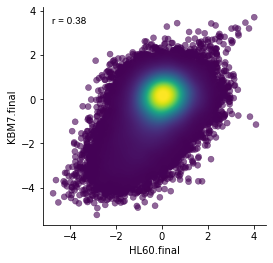

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_map={'HL60.final': 'HL60.initial', 'KBM7.final': 'KBM7.initial'})
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(lfc_df, x = 'HL60.final', y = 'KBM7.final')
gpplot.add_correlation(lfc_df, x = 'HL60.final', y = 'KBM7.final')
sns.despine()

We have to get our sgRNA sequences from the encoded sgRNAs

In [5]:
reannotated_lfcs = lfc_df.copy()
reannotated_lfcs['Position'] = reannotated_lfcs['sgRNA'].str.extract('([0-9]+)$').astype(float)
reannotated_lfcs['pos_strand'] = reannotated_lfcs['sgRNA'].str.contains('_p[0-9]')
reannotated_lfcs['Strand'] = reannotated_lfcs['pos_strand'].apply(lambda x: '+' if x else '-')
clean_annotations = (annotations[['Gene Symbol', 'Position', 'Strand', 'Sequence']]
                    .rename({'Gene Symbol': 'Gene', 'Sequence': 'sgRNA Sequence'}, axis=1))
reannotated_lfcs = (reannotated_lfcs.merge(clean_annotations, how='inner', on=['Gene', 'Strand', 'Position'])
                    .drop(['Position', 'pos_strand', 'Strand', 'sgRNA'], axis=1))

In [6]:
sg_list = list(reannotated_lfcs['sgRNA Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
long_lfcs = reannotated_lfcs.melt(id_vars=['sgRNA Sequence'], value_vars=['KBM7.final', 'HL60.final'],
                                  var_name='condition', value_name='lfc')

In [8]:
lfcs_designs = (long_lfcs
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.gene,
                                fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                score_col='lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,HL60.final,0.680324
1,KBM7.final,0.759725


In [9]:
roc_aucs['ROC-AUC'].mean()

0.7200244316930582

In [10]:
sg_counts = (reads.Gene
             .value_counts()
             .reset_index(name='n_guides')
             .rename({'index': 'gene'}, axis=1))
ribosomal_genes = sg_counts.gene[sg_counts.n_guides > 10]
ess_ribo_genes = ribosomal_genes[ribosomal_genes.isin(essential_genes.gene)]
len(ess_ribo_genes)

29

In [11]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(ess_ribo_genes)]
filtered_sgs = relevant_sgs_designs[(relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(relevant_sgs_designs.shape[0] - filtered_sgs.shape[0]))

Off target filtered: 112


In [12]:
filtered_sgs['neg_lfc'] = -filtered_sgs['lfc']
filtered_sgs = add_transform_col(df=filtered_sgs,
                                 col='neg_lfc',
                                 transform_name='yeo-johnson',
                                 transformed_name='scaled_neg_lfc',
                                 group_col='Target Gene Symbol')
sg_avg_score = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                     'Target Cut %', 'On-Target Efficacy Score'])
                .agg({'scaled_neg_lfc': 'mean'})
                .reset_index())

In [13]:
reannotated_lfcs[reannotated_lfcs['sgRNA Sequence'].isin(sg_avg_score['sgRNA Sequence'])].corr()

,HL60.final,KBM7.final
HL60.final,1.000000,0.655831
KBM7.final,0.655831,1.000000


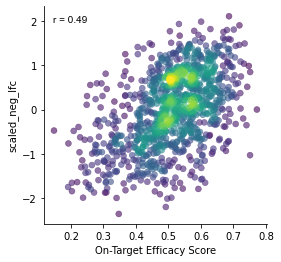

In [14]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_score, y='scaled_neg_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_score, y='scaled_neg_lfc', x='On-Target Efficacy Score')
sns.despine()

In [15]:
training_data = sg_avg_score.drop('On-Target Efficacy Score', axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,scaled_neg_lfc
0,AAACAAGAAGAGGGTCCTGC,TTCAAAACAAGAAGAGGGTCCTGCTGGGAG,RPS11,14.7,-1.314598
1,AAACACCTTGGCCCGCCGGA,GGAAAAACACCTTGGCCCGCCGGAAGGGCA,RPL19,35.7,-1.137158
2,AAACACTCACCGATCTGTGA,ACACAAACACTCACCGATCTGTGAAGGAGT,RPS13,31.6,0.092327
3,AAACCTCCAGGTTGACCTCT,AATTAAACCTCCAGGTTGACCTCTTGGGCT,RPL22L1,8.4,-0.249004
4,AAACGTCCCACATGCCCACC,GCAGAAACGTCCCACATGCCCACCAGGAGC,RPL4,56.8,0.085087
...,...,...,...,...,...
1017,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,RPL7,13.5,-0.733651
1018,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,RPL7,93.0,0.715594
1019,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,RPS4X,94.1,-1.302978
1020,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,RPL8,35.5,-1.341252


In [16]:
training_data.to_csv('../data/processed/Wang2014_activity.csv', index=False)